# ASR Punctuation Restoration Experiments
By Bart Pleiter S4752740 for the course ASR 2021-2022

## Imports and setup

In [1]:
# imports
import os
import re
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras import mixed_precision
import tensorflow_addons as tfa
from tensorflow.keras.utils import Sequence
import tensorflow.keras.backend as kb

from transformers import BertTokenizer
from transformers import TFBertModel

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import more_itertools as mit

In [2]:
# use mixed precision to speed up training on my RTX3050
mixed_precision.set_global_policy('mixed_float16')

memoryLimit = 6500 # 6.5GB to leave some free memory for other processes

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memoryLimit)]
        )
    except RuntimeError as e:
        print(e)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050, compute capability 8.6


## Hyperparameters

In [3]:
# flags
RETRAIN_MODEL = False # retrain the model if true, else load weights from checkpoint

# hyperparameters
batchSize = 32 # batch size
numLabels = 4 # number of labels for each token
seqLen = 64 # sequence length to give to BERT (max 512)
dropout = 0.5 # dropout amount for the dropout layers
learningRate = 1e-5 # learning rate during training
epochs = 3 # number of epochs for the training process
seqShift = 8 # length of sequence shifting for creating the inputs (lower = more predictions per token)

# labels
LABEL_NOTHING = 0
LABEL_COMMA = 1
LABEL_PERIOD = 2
LABEL_QUESTION = 3
labelNames = ["O", "COMMA", "PERIOD", "QUESTION"]

# encode the punctuation label as a number
punctEncode = {
    "O": LABEL_NOTHING,
    "COMMA": LABEL_COMMA,
    "PERIOD": LABEL_PERIOD,
    "QUESTION": LABEL_QUESTION
}

# decode the label for printing purposes
punctDecode = {v: k for k, v in punctEncode.items()}

# path of datasets (add / at the end)
dataPath = "IWSLTche/Data/"

# which BERT network to use
modelName = "bert-base-uncased"

# setup BERT and its tokenizer
tokenizer = BertTokenizer.from_pretrained(modelName)
bert_layer = TFBertModel.from_pretrained(modelName)

# setup checkpoints
checkpoint_path = "checkpoints/IWSLTcheBERTbaseUncased_{epoch:02d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_best_only=False)

# which checkpoint to restore if RETRAIN_MODEL is false
checkpointPath = "checkpoints/IWSLTcheBERTbaseUncased_01.ckpt" #tf.train.latest_checkpoint(checkpoint_dir)

2022-05-18 20:32:51.323548: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-18 20:32:51.781660: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6500 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050, pci bus id: 0000:07:00.0, compute capability: 8.6
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are i

## Dataset preparation

Loads a preprocessed dataset from file and creats chunks with overlap.
See other notebooks (like IWSLTchePrepare.ipynb) for the preprocessing steps!

In [4]:
# read the processed dataset from file
# also create chunks of seqLen with padding
# padding works as follows:
#  to give each token the same amount of predictions, padding of seqLen-1 will be applied
#  to both the start and end of the data
def getPreparedDataset(prefix, shift=True):
    def padAndChunkWindowed(data):
        data = np.pad(data, (seqLen-1, seqLen-1), mode='constant')
        return np.array(list(mit.windowed(data, seqLen, fillvalue=0, step=seqShift)), dtype="int32")

    with open(dataPath + modelName + "/" + prefix + "_data.pkl", 'rb') as f:
        X, Y = pickle.load(f)
    return padAndChunkWindowed(X), padAndChunkWindowed(Y), len(Y)

trainX, trainY, lenTrain = getPreparedDataset("train")
valX, valY, lenVal = getPreparedDataset("valid")
testX, testY, lenTest = getPreparedDataset("test")


In [5]:
print(trainX.shape, lenTrain)
print(valX.shape, lenVal)
print(testX.shape, lenTest)

(284884, 64) 2279001
(40160, 64) 321207
(1706, 64) 13578


## Model creation

In [6]:
# custom loss function which replaces the -1 labels and predictions at that place with 0
#  to exclude subwords from calculating the loss
#  and so it can be used to calculate the sparse categorical crossentropy, which does not work with -1
def customSparseCategoricalCrossEntropy(y_actual,y_pred):
    y_actual = tf.where(y_actual == -1, 0, y_actual)
    y_pred = tf.boolean_mask(y_pred, y_actual != -1)
    loss=kb.sparse_categorical_crossentropy(y_actual, y_pred)
    
    # mean is not really needed
    #loss=kb.mean(loss, axis=-1)
    #loss=kb.mean(loss, axis=-1)
    
    return loss

In [7]:
# model construction

# input layer (batchSize, seqLen)
bert_input = tf.keras.Input(shape=(seqLen), dtype='int32', name='bert_input')

# get embeddings for each token from BERT layer (batchSize, seqLen, 768)
x = bert_layer(bert_input)[0]

# do dropout
x = tf.keras.layers.Dropout(dropout, name="dropout1")(x)

# fully connected layer 768 -> 768x2
x = tf.keras.layers.Dense(1536, name='linearExtra')(x)

# do dropout
x = tf.keras.layers.Dropout(dropout, name="dropoutExtra")(x)

# relu activation on fully connected layer output
x = tf.keras.layers.Activation('relu', name='relu')(x)

# fully connected output layer
x = tf.keras.layers.Dense(numLabels, name='linear')(x)

# softmax activation on output layer
model_out = tf.keras.layers.Activation('sigmoid', dtype='float32', name='softmax')(x)

model = tf.keras.Model(inputs=bert_input, outputs=model_out, name='model')
model.compile(
    tf.keras.optimizers.Adam(learning_rate=learningRate),
    loss=customSparseCategoricalCrossEntropy,
    metrics=tf.keras.metrics.SparseCategoricalAccuracy()
)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert_input (InputLayer)     [(None, 64)]              0         
                                                                 
 tf_bert_model (TFBertModel)  TFBaseModelOutputWithPoo  109482240
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             64, 768),                           
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                             

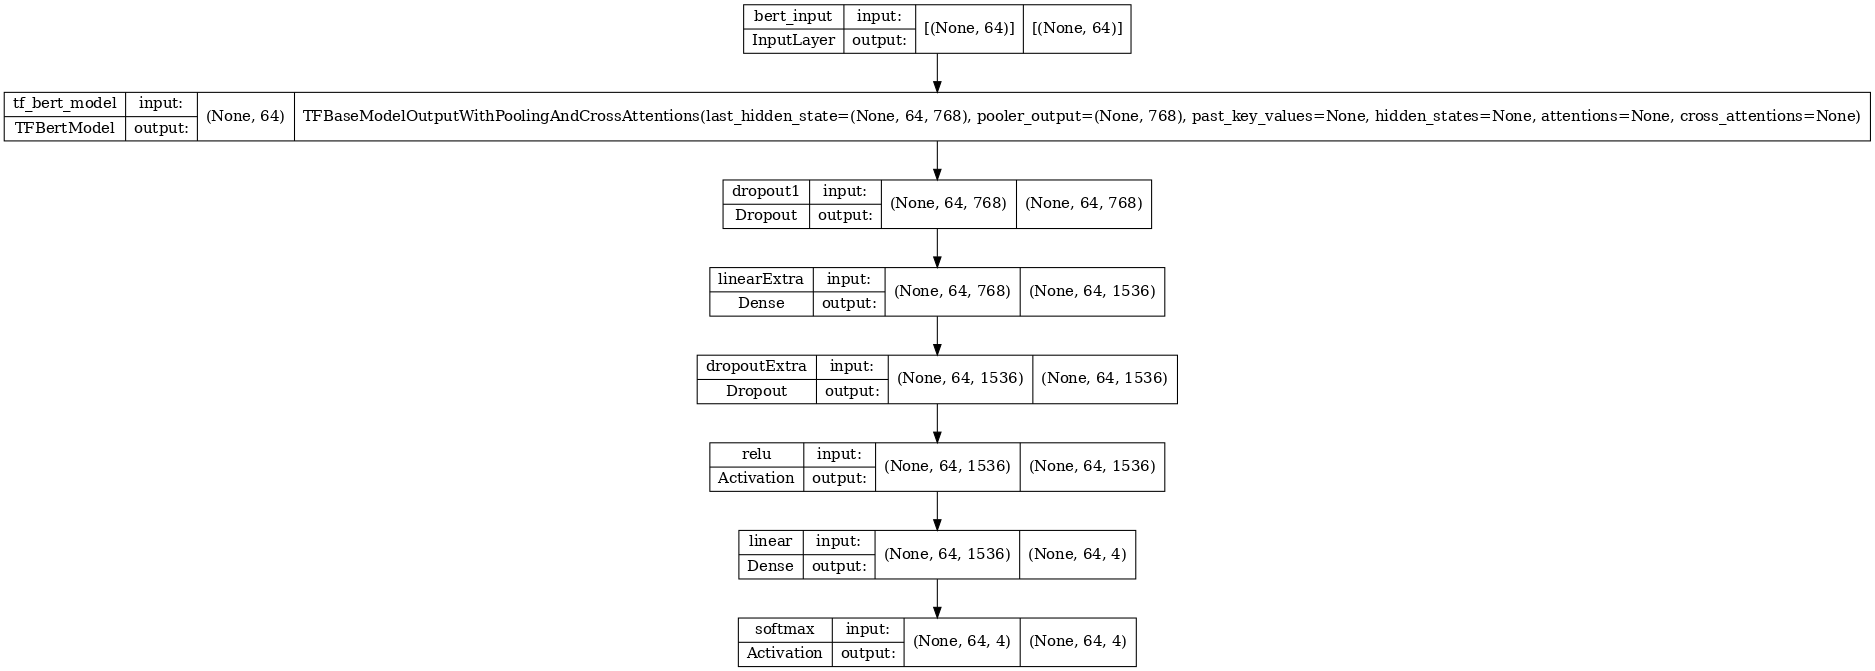

In [8]:
# plot the model architecture
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, dpi=76)

## Training

In [9]:
if RETRAIN_MODEL:
    # training the data
    history = model.fit(
        trainX, trainY,
        #validation_split=0.2,
        epochs=epochs,
        shuffle=True,
        batch_size=batchSize,
        validation_data=(valX, valY),
        callbacks=[cp_callback]#tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=2)
    )
else:
    model.load_weights(checkpointPath)

In [10]:
if RETRAIN_MODEL:
    # show the fitting history
    history.history

    # plot the loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

## Evaluation

In [11]:
# to obtain the indexes of a token in all predictions containing the token
predictionsPerToken = seqLen // seqShift
def getIndexOfPrediction(i):
    x = []
    y = []
    x0 = seqLen - (seqShift-(i-1) % seqShift)
    y0 = (seqShift-1 + i) // seqShift
    for p in range(predictionsPerToken):
        x.append(x0 - p*predictionsPerToken)
        y.append(y0 + p)
    
    return y, x

In [12]:
# evaluates the predicted results
# by taking the mean of multiple predictions from the sliding window
# and removing the subwords from data (indicated by the -1 true label)
def evaluateResults(Ytrue, Ypred, lenData):
    
    noWindowYtrue = []
    noWindowYpred = []
    
    for i in range(lenData):
        ylist, xlist = getIndexOfPrediction(i)
        predValues = []
        # add the prediction for each token
        for n in range(len(ylist)):
            predValues.append(Ypred[ylist[n]][xlist[n]])
        
        # add the true label for the current token
        noWindowYtrue.append(Ytrue[ylist[0]][xlist[0]])
                
        # take the mean of each prediction
        predValues = np.array(np.mean(predValues, axis=0))
        
        noWindowYpred.append(predValues)
        
    # select best class for each token
    noWindowYpred = np.array(noWindowYpred).argmax(axis=-1)    
    
    # apply mask to ignore (remove) subwords from the arrays
    noWindowYtrue = np.array(noWindowYtrue)
    wordMask = noWindowYtrue != -1
    Ypred = noWindowYpred[wordMask]
    Ytrue = np.array(noWindowYtrue[wordMask])
    
    print(classification_report(Ytrue, Ypred, target_names=labelNames))
    
    confusionMatrix = confusion_matrix(Ytrue, Ypred)
    disp = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix, display_labels=labelNames)
    print("Confusion matrix:")
    disp.plot()
    plt.show()

# Validation set

In [13]:
# generate output on validation data
testPredict = model.predict(testX)

              precision    recall  f1-score   support

           O       0.99      0.99      0.99     10984
       COMMA       0.74      0.70      0.72       830
      PERIOD       0.81      0.88      0.85       806
    QUESTION       0.80      0.87      0.83        46

    accuracy                           0.96     12666
   macro avg       0.84      0.86      0.85     12666
weighted avg       0.96      0.96      0.96     12666

Confusion matrix:


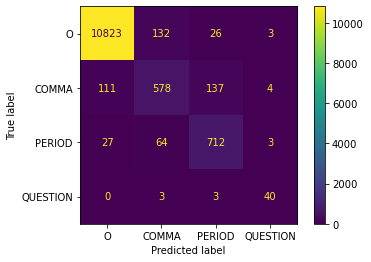

In [14]:
evaluateResults(testY, testPredict, lenTest)

# Test set

In [ ]:
# loading the data for testing
Xtest, Ytest, testTokens = loadDataFromTEDtalkDataset("IWSLT2012data/test2011", tokenizer)
Xtestasr, Ytestasr, testasrTokens = loadDataFromTEDtalkDataset("IWSLT2012data/test2011asr", tokenizer)

In [ ]:
# generate output on test data
testPredict = model.predict(Xtest)
testPredictasr = model.predict(Xtestasr)

# select best class for each token
resultYtest = testPredict.argmax(axis=1)
resultYtestasr = testPredictasr.argmax(axis=1)

In [ ]:
print("Test set:")
evaluateResults(Ytest, resultYtest)

print("Test ASR set:")
evaluateResults(Ytestasr, resultYtestasr)

In [ ]:
# evaluate on test data
#resultsTest = model.evaluate(Xtest, Ytest, batch_size=batchSize)
#print("test loss, test acc:", resultsTest)

#resultsTestasr = model.evaluate(Xtest, Ytest, batch_size=batchSize)
#print("test (asr) loss, test (asr) acc:", resultsTest)

In [ ]:
# show the restoration on the test sets
# get results
#restoreTest = model.predict(Xtest)
#restoreTestasr = model.predict(Xtestasr)

# select best class for each token
#resultYtest = restoreTest.argmax(axis=1)
#resultYtestasr = restoreTestasr.argmax(axis=1)

# reconstruct text with predicted tokens
#resTextTest = reconstructText(testTokens, resultYtest, tokenizer)
#resTextTestasr = reconstructText(testasrTokens, resultYtestasr, tokenizer)

In [ ]:
#print(resTextTest)

In [ ]:
#print(resTextTestasr)

In [ ]:
# example restoration on paragraph from a story
#toPredict = "Then he sat down and began to reflect. In the morning he must find seconds. Whom should he choose? He searched his mind for the most important and celebrated names of his acquaintance. At last he decided on the Marquis de la Tour-Noire and Colonel Bourdin, an aristocrat and a soldier; they would do excellently. Their names would look well in the papers. He realised that he was thirsty, and drank three glasses of water one after the other; then he began to walk up and down again. He felt full of energy. If he played the gallant, showed himself determined, insisted on the most strict and dangerous arrangements, demanded a serious duel, a thoroughly serious duel, a positively terrible duel, his adversary would probably retire an apologist."
#predictText(toPredict, model, tokenizer)

In [ ]:


def insertTarget(x, segment_size):
    # creates segments of surrounding words for each word in x.
    # inserts a zero token ([PAD]) halfway the segment, right after the inserted token.
    # for the first segmentSize/2 tokens, the end of the data is used, as if the text loops
    X = []
    x_pad = x[-((segment_size-1)//2-1):]+x+x[:segment_size//2]

    for i in range(len(x_pad)-segment_size+2):
        segment = x_pad[i:i+segment_size-1]
        segment.insert((segment_size-1)//2, 0)
        X.append(segment)

    return np.array(X)

def encodeRawText(text):
    # splits the text on spaces and creates labels for each created token
    # the resulting token list will have no punctuation anymore
    splitOnSpace = text.split(' ')
    X = []
    Y = []
    
    for word in splitOnSpace:
        if len(word) > 0: # skip empty tokens
            # look for tokens at the end of the word
            # remove if found when appending to X
            # also make everything lowercase
            if word[-1] == '.':
                X.append(word.lower()[:-1])
                Y.append(LABEL_PERIOD)
            elif word[-1] == ',':
                X.append(word.lower()[:-1])
                Y.append(LABEL_COMMA)
            elif word[-1] == '?':
                X.append(word.lower()[:-1])
                Y.append(LABEL_QUESTION)
            else:
                X.append(word.lower())
                Y.append(LABEL_NOTHING)
                
    return X, Y

def prepareDataForModel(words, labels, tokenizer):
    # returns a list of segments of token IDs for X
    #  and a list of label tokens for y, corresponding to the segment in X
    #  and a list of the unsegmented token IDs, for easier reconstruction
    X = []
    Y = []
    for word, label in zip(words, labels):
        y = [label]
        # retokenize x
        x = tokenizer.wordpiece_tokenizer.tokenize(word)
        # encode x
        x = tokenizer.convert_tokens_to_ids(x)

        # do not add if tokenize failed
        if len(x) > 0:
            # if multiple tokens, create multiple labels of 0
            #  set the last one to the real label
            if len(x) > 1:
                y = (len(x)-1)*[0]+y
            X += x
            Y += y
                
    # create segments for X, and return together with Y, and the unsegmented tokens
    # return as Numpy array
    return np.array(insertTarget(X, segmentSize)), np.array(Y), X

def getTokenFromSegment(segment):
    # is always at the same place of the segment (assumes even numbers!)
    return segment[segmentSize//2-2]

def reconstructText(tokenList, labels, tokenizer):
    # reconstructs text by detokenizing and applying the given labels
    tokens = tokenizer.convert_ids_to_tokens(tokenList)
    
    reconstructedText = ""
    for tok, label in zip(tokens, labels):
        # no space in between if second token starts with '##'
        if tok.startswith("##"):
            reconstructedText += tok[2:]
        else:
            reconstructedText += " " + tok
        
        # add the punctuation from the label
        if label == LABEL_COMMA:
            reconstructedText += ","
        elif label == LABEL_PERIOD:
            reconstructedText += "."
        elif label == LABEL_QUESTION:
            reconstructedText += "?"
                
    reconstructedText = reconstructedText[1:] # skip the first space
    
    return reconstructedText
    
def loadDataFromFile(path):
    # creates a dataset from a text file, which can be used on the model
    # returns a list of segments of token IDs for X
    #  and a list of label tokens for y, corresponding to the segment in X
    #  and a list of the unsegmented token IDs, for easier reconstruction
    text = ""
    with open(path, 'r') as file:
        text = file.read()
        
    X, Y = encodeRawText(text)
    dataX, dataY, dataTokens = prepareDataForModel(X, Y, tokenizer)
    
    return dataX, dataY, dataTokens

def loadDataFromTEDtalkDataset(path, tokenizer):
    # loads the data from the TED talk dataset, which is already pre-processed
    # returns a list of segments of token IDs for X
    #  and a list of label tokens for y, corresponding to the segment in X
    #  and a list of the unsegmented token IDs, for easier reconstruction
    X = []
    Y = []
    with open(path, "rb") as file:
        for line in file:
            # dataset uses \r\n for newlines
            word, punc = line.decode('utf-8', errors='ignore').replace('\r\n', '').split('\t')
            # encode y
            y = [punctEncode[punc]]
            # retokenize x
            x = tokenizer.wordpiece_tokenizer.tokenize(word)
            # encode x
            x = tokenizer.convert_tokens_to_ids(x)
            
            # do not add if tokenize failed
            if len(x) > 0:
                # if multiple tokens, create multiple labels of 0
                #  set the last one to the real label
                if len(x) > 1:
                    y = (len(x)-1)*[0]+y
                X += x
                Y += y
                
    # create segments for X, and return together with Y, and the unsegmented tokens
    # return as Numpy array
    return np.array(insertTarget(X, segmentSize)), np.array(Y), X

def predictText(text, model, tokenizer):
    # predicts the punctuation for a given text and print the resulting text
    
    # pre-process
    X, Y = encodeRawText(text)
    dataX, dataY, dataTokens = prepareDataForModel(X, Y, tokenizer)
    
    # get results
    results = model.predict(dataX)
    
    # select best class for each token
    resultY = results.argmax(axis=1)
    
    # reconstruct text with predicted tokens
    resText = reconstructText(dataTokens, resultY, tokenizer)
    
    print(resText)

In [ ]:
"""
class Generator(Sequence):
    
    def __init__(self, X, Y, isTrain=False):
        self.encoded_texts = np.array(X)
        self.targets = np.array(Y)
        self.isTrain = isTrain
        self.indexs = np.arange(len(X))
    
    def __len__(self):
        return len(self.encoded_texts)//seqLen - 1

    def __getitem__(self, index):
        #shift = np.random.randint(seqShift) - seqShift // 2\
        #    if self.isTrain else 0

        start_idx = index * seqLen# + shift
        start_idx = max(0, start_idx)
        end_idx = start_idx + seqLen
        return np.array([self.encoded_texts[start_idx: end_idx]]), np.array([self.targets[start_idx: end_idx]])
"""
"""
class DataGen(Sequence):
    def __init__(self, batch_size, isTrain=False, X, Y):
        self.encoded_texts = np.array(X)
        self.targets = np.array(Y)
        self.isTrain = isTrain
        self.indexs = np.arange(len(X))
        self.batch_size = batch_size

    def __len__(self):
        return len(self.encoded_texts)//seqLen - 1

    def __getitem__(self, i):
        start_idx = i * seqLen# + shift
        start_idx = max(0, start_idx)
        end_idx = start_idx + seqLen
        return self.encoded_texts[start_idx: end_idx], self.targets[start_idx: end_idx]
        
        batch = self.samples[i * self.batch_size:(i + 1) * self.batch_size]
        return self.preproc.process(*zip(batch))

    def on_epoch_end(self):
        shuffle(self.samples)
"""

#train_gen = Generator(valX, valY, isTrain=True)
#data_gen = DataGen(batchSize, True, valX, valY)
#myit = iter(train_gen)
#print(next(myit))

#X1 = []
#X2 = []
#X3 = []
#Y1 = []

#for i in range(64):
#    a, b = next(myit)
#    X1.append(a)
#    X2.append([1] * seqLen)
#    X3.append([0] * seqLen)
#    Y1.append(b)

#train_data = train_data.shuffle(shuffle_buffer_size)
#train_data = train_data.batch(batch_size)

# print(train_gen)

#print(Y1)

# test
#X, y = next(iter(train_data))
#print(X[0].numpy())

#print(tokenizer.decode(X[0].numpy()))
#print()
#print(tokenizer.decode(X[1].numpy()))
#print()
#print(tokenizer.decode(X[2].numpy()))
#print()
#print(tokenizer.decode(X[3].numpy()))

In [ ]:
#testX, testY = getPreparedDataset("test")

#print(testX.shape)

#results = model.predict(testX)

# select best class for each token
#resultY = results.argmax(axis=-1)



In [ ]:
# text preprocessing demo
if False:
    s = "Tyranosaurus: kill me? Not enough, -- said the co-pilot -- ..."
    s = clean_text(s)
    X, Y = encodeRawText(s)
    data, targets = create_target(s)
    print(X)
    print(Y)
    print(data)
    print(targets)
    print([tokenizer._convert_id_to_token(d) for d in data[1:-1]])

In [ ]:
if RECREATE_PICKLE:
    # loading data
    with open(dataPath + "train_texts.txt", 'r', encoding="utf-8") as f:
        train_text = f.readlines()
    with open(dataPath + "dev_texts.txt", 'r', encoding="utf-8") as f:
        valid_text = f.readlines()
    with open(dataPath + "test_texts_2012.txt", 'r', encoding="utf-8") as f:
        test_text = f.readlines()

    # put all datasets together for easy batch operations
    datasets = train_text, valid_text, test_text

In [ ]:
# prepare data for the model
# code comes mostly from neural-punctuator by attilanagy234
def clean_text(text):
    
    # replacing special tokens
    text = text.replace('!', '.')
    text = text.replace(':', ',')
    text = text.replace('--', ',')
    
    reg = "(?<=[a-zA-Z])-(?=[a-zA-Z]{2,})"
    r = re.compile(reg, re.DOTALL)
    text = r.sub(' ', text)
    
    text = re.sub(r'\s-\s', ' , ', text)
    
    text = text.replace(';', '.')
    text = text.replace(' ,', ',')
    text = text.replace('♫', '')
    text = text.replace('...', '')
    text = text.replace('.\"', ',')
    text = text.replace('"', ',')

    text = re.sub(r'--\s?--', '', text)
    text = re.sub(r'\s+', ' ', text)
    
    text = re.sub(r',\s?,', ',', text)
    text = re.sub(r',\s?\.', '.', text)
    text = re.sub(r'\?\s?\.', '?', text)
    text = re.sub(r'\s+', ' ', text)
    
    text = re.sub(r'\s+\?', '?', text)
    text = re.sub(r'\s+,', ',', text)
    text = re.sub(r'\.[\s+\.]+', '. ', text)
    text = re.sub(r'\s+\.', '.', text)
    
    return text.strip().lower()

target_token2id = {t: tokenizer.encode(t)[-2] for t in ",.?"}
target_ids = list(target_token2id.values())
target_ids

id2target = {
    0: 0,
    -1: -1,
}

for i, ti in enumerate(target_ids):
    id2target[ti] = i+1

def create_target(text):
    encoded_words, targets = [], []
    
    words = text.split(' ')

    for word in words:
        target = 0
        for target_token, target_id in target_token2id.items():
            if word.endswith(target_token):
                word = word.rstrip(target_token)
                target = id2target[target_id]

        encoded_word = tokenizer.encode(word, add_special_tokens=False)
        
        for w in encoded_word:
            encoded_words.append(w)
        for _ in range(len(encoded_word)-1):
            targets.append(-1)
        targets.append(target)
        
        #print([tokenizer._convert_id_to_token(ew) for ew in encoded_word], target)
        assert(len(encoded_word)>0)

    encoded_words = [tokenizer.cls_token_id or tokenizer.bos_token_id] +\
                    encoded_words +\
                    [tokenizer.sep_token_id or tokenizer.eos_token_id]
    targets = [-1] + targets + [-1]
    
    return encoded_words, targets

In [ ]:
if RECREATE_PICKLE:
    # clean the special characters from the texts
    datasets = [[clean_text(text) for text in ds] for ds in datasets]

    # encode the texts and generate labels
    encoded_texts, targets = [], []

    for ds in datasets:
        x = list(zip(*(create_target(ts) for ts in tqdm(ds))))
        encoded_texts.append(x[0])
        targets.append(x[1])

    print(encoded_texts[1][0][:10])
    print(targets[1][0][:10])

    # make folder for prepared dataset for specific BERT model
    os.makedirs(dataPath + modelName, exist_ok=True)

    # store
    for i, name in enumerate(('train', 'valid', 'test')):
        with open(dataPath + f'{modelName}/{name}_data.pkl', 'wb') as f:
            pickle.dump((encoded_texts[i], targets[i]), f)